# Leukocyte recognition (selection + classification) using simple CNN and DenseNet with Fine Tuning

**Dataset** and **annotations.csv** from [**GitHub**](https://github.com/Shenggan/BCCD_Dataset)<br>
**Augmented dataset** and **labels.csv** from [**Kaggle**](https://www.kaggle.com/datasets/paultimothymooney/blood-cells)

In [1]:
import os
import random

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt

import cv2
import imutils
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix

In [2]:
TRAIN_IMAGES_PATH = 'dataset_augmented/images/TRAIN/'
TEST_IMAGES_PATH = 'dataset_augmented/images/TEST/'
TEST_SIMPLE_IMAGES_PATH = 'dataset_augmented/images/TEST_SIMPLE/'
CLASS_NAMES = os.listdir(TRAIN_IMAGES_PATH)
IMAGE_SIZE = (60, 60)
IMAGE_SHAPE = IMAGE_SIZE + (3,)

In [3]:
def load_image(path):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

## Dataset overview

Labeled image

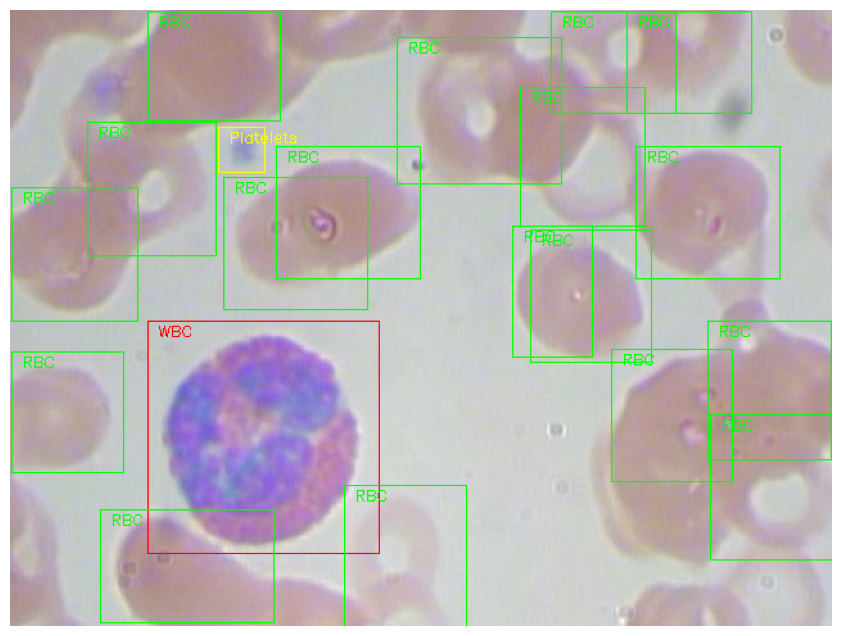

In [4]:
image_name = random.choice(os.listdir('dataset/images/'))

plt.figure(figsize=(12, 8))
plt.axis('off')

image = load_image(path='dataset/images/'+image_name)

annotations = pd.read_csv('dataset/annotations.csv')
for index, row in annotations[annotations['filename']==image_name].iterrows():
    xmin = row['xmin']
    ymin = row['ymin']
    xmax = row['xmax']
    ymax = row['ymax']
    
    if row['cell_type'] == 'RBC':
        cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (0, 255, 0), 1)
        cv2.putText(image, 'RBC', (xmin+8, ymin+12), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 255, 0))
    if row['cell_type'] == 'Platelets':
        cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (255, 255, 0), 1)
        cv2.putText(image, 'Platelets', (xmin+8, ymin+12), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 0))
    if row['cell_type'] == 'WBC':
        cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (255, 0, 0), 1)
        cv2.putText(image, 'WBC', (xmin+8, ymin+12), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 0, 0))

plt.imshow(image)
plt.show()

Plot images

In [5]:
images_sample = pd.DataFrame()
sample = random.sample(os.listdir('dataset/images/'), 20)
labels = pd.read_csv('dataset/labels.csv')
class_names = [labels.loc[labels['Image']==int(image[11:16]), 'Category'].values[0] for image in sample]
sample = ['dataset/images/' + i for i in sample]
images_sample['File'] = sample
images_sample['Class'] = class_names

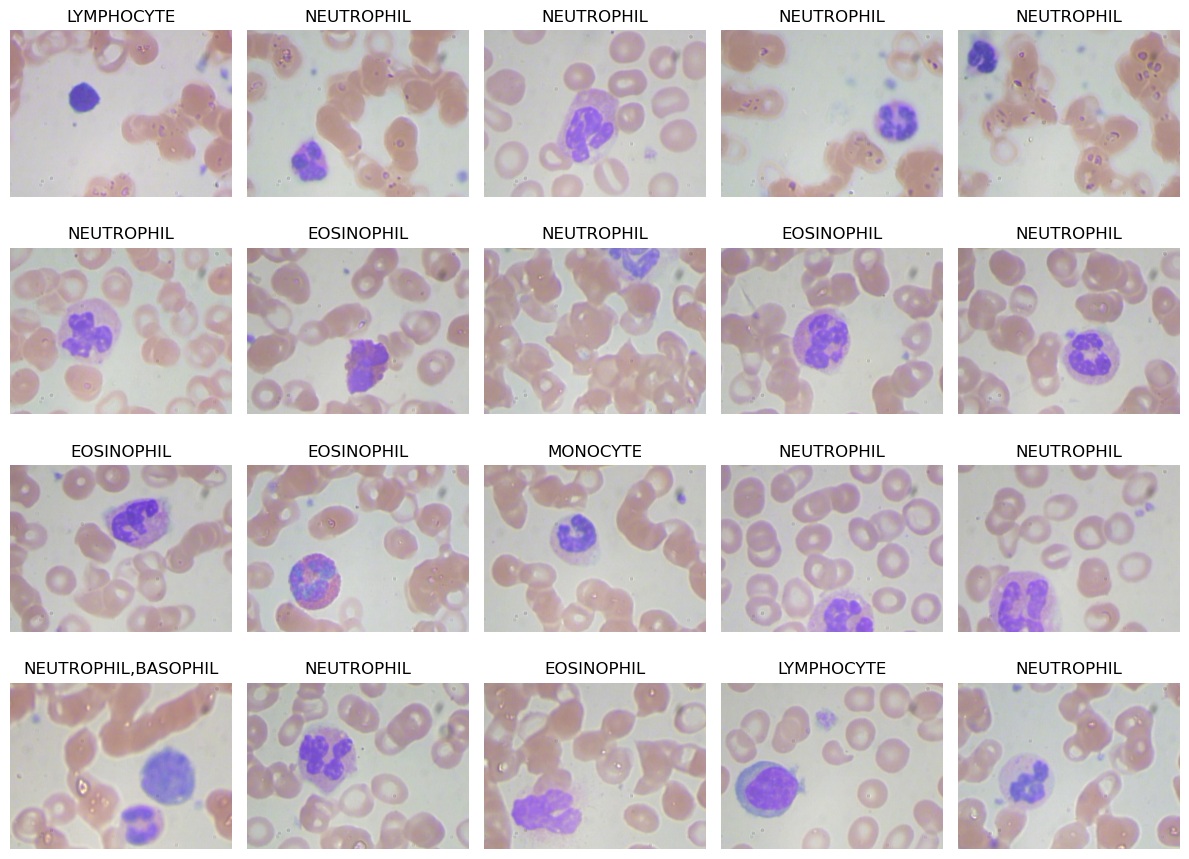

In [6]:
plt.figure(figsize=(12, 9))
for i in range(len(images_sample)):
    plt.subplot(4, 5, i+1)
    plt.axis('off')
    image = load_image(images_sample['File'][i])
    plt.imshow(image)
    plt.title(images_sample['Class'][i])
plt.tight_layout()
plt.show()

Samples summary

In [7]:
labels = pd.read_csv('dataset/labels.csv')
summary = labels['Category'].value_counts()
print(summary)
print()
print(f"Total samples: {summary.sum()}")

NEUTROPHIL                207
EOSINOPHIL                 88
LYMPHOCYTE                 33
MONOCYTE                   21
BASOPHIL                    3
NEUTROPHIL, NEUTROPHIL      3
NEUTROPHIL, EOSINOPHIL      2
EOSINOPHIL, EOSINOPHIL      1
NEUTROPHIL,EOSINOPHIL       1
LYMPHOCYTE, LYMPHOCYTE      1
MONOCYTE, LYMPHOCYTE        1
NEUTROPHIL, MONOCYTE        1
EOSINOPHIL, LYMPHOCYTE      1
EOSINOPHIL,EOSINOPHIL       1
NEUTROPHIL,BASOPHIL         1
NEUTROPHIL,NEUTROPHIL       1
NEUTROPHIL, LYMPHOCYTE      1
Name: Category, dtype: int64

Total samples: 367


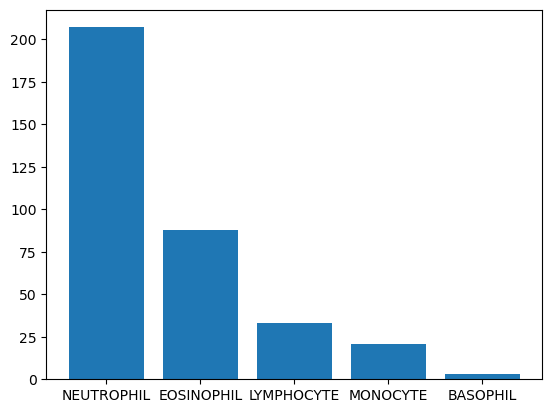

In [8]:
plt.bar(summary.head(5).index.tolist(), summary.head(5).tolist())
plt.show()

Plot augmented images

In [9]:
images_sample = pd.DataFrame()
for class_name in CLASS_NAMES:
    df = pd.DataFrame()
    sample = random.sample(os.listdir(TRAIN_IMAGES_PATH+class_name), 5)
    sample = [TRAIN_IMAGES_PATH + class_name + '/' + i for i in sample]
    df['File'] = sample
    df['Class'] = class_name
    images_sample = pd.concat([images_sample, df], ignore_index=True)

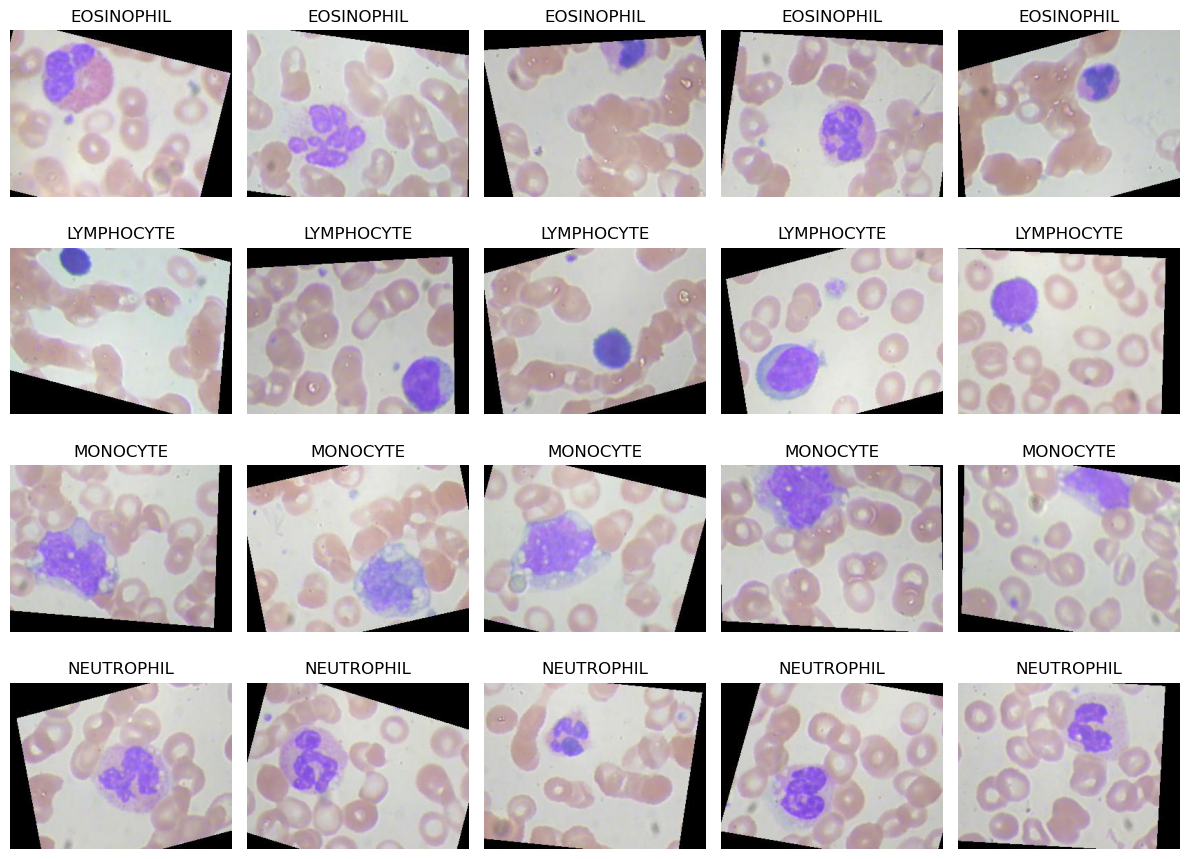

In [10]:
plt.figure(figsize=(12, 9))
for i in range(len(images_sample)):
    plt.subplot(4, 5, i+1)
    plt.axis('off')
    image = load_image(images_sample['File'][i])
    plt.imshow(image)
    plt.title(images_sample['Class'][i])
plt.tight_layout()
plt.show()

Summary of augmented training and test samples

In [11]:
print("Training set")
training_set_summary = pd.Series(
    data=[len(os.listdir(TRAIN_IMAGES_PATH+class_name)) for class_name in CLASS_NAMES],
    index=CLASS_NAMES
)
print(training_set_summary)
print(f"Total samples: {training_set_summary.sum()}")
print()

print("Test set")
test_set_summary = pd.Series(
    data=[len(os.listdir(TEST_IMAGES_PATH+class_name)) for class_name in CLASS_NAMES],
    index=CLASS_NAMES
)
print(test_set_summary)
print(f"Total samples: {test_set_summary.sum()}")

Training set
EOSINOPHIL    2497
LYMPHOCYTE    2483
MONOCYTE      2478
NEUTROPHIL    2499
dtype: int64
Total samples: 9957

Test set
EOSINOPHIL    623
LYMPHOCYTE    620
MONOCYTE      620
NEUTROPHIL    624
dtype: int64
Total samples: 2487


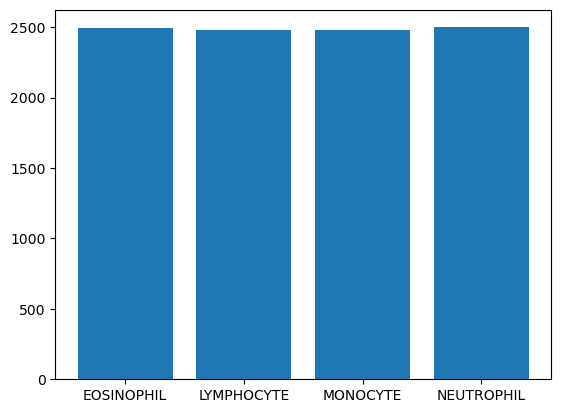

In [12]:
plt.bar(training_set_summary.index.tolist(), training_set_summary.tolist())
plt.show()

## Loading data

Function to encode class labels

In [4]:
def label_code(label):
    code = {
        "EOSINOPHIL": 0,
        "LYMPHOCYTE": 1,
        "MONOCYTE": 2,
        "NEUTROPHIL": 3
    }
    
    if type(label) == str:
        return code[label]
    else:
        for key, value in code.items():
            if value == label:
                return key

Functions for image preprocessing

In [5]:
def find_edges(image):
    gray = cv2.GaussianBlur(image, (1, 1), 0)
    edged_image = cv2.Canny(gray, 100, 400)
    edged_image = cv2.dilate(edged_image, None, iterations=1)
    edged_image = cv2.erode(edged_image, None, iterations=1)
    return edged_image

def get_image_contours(image):
    contours = cv2.findContours(image.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = imutils.grab_contours(contours)
    contours = sorted(contours, key=lambda x: cv2.contourArea(x))
    return contours

def get_boxes(contours):
    boxes = []
    centers = []
    for contour in contours:
        box = cv2.minAreaRect(contour)
        box = cv2.cv.BoxPoints(box) if imutils.is_cv2() else cv2.boxPoints(box)
        box = np.array(box, dtype='int')
        (tl, tr, br, bl) = box
        if (sp.spatial.distance.euclidean(tl, bl)) > 0 and (sp.spatial.distance.euclidean(tl, tr)) > 0:
            boxes.append(box)
    return boxes

def preprocess_image(image):
    # Add padding to the image to better detect cell at the edge
    image = cv2.copyMakeBorder(image, 10, 10, 10, 10, cv2.BORDER_CONSTANT, value=[198, 203, 208])
    
    # Thresholding the image to get the target cell
    image_1 = cv2.inRange(image, (80, 80, 180), (180, 170, 245))
    
    # Opening errosion then dilation
    kernel = np.ones((3, 3), np.uint8)
    kernel_1 = np.ones((5, 5), np.uint8)
    image_erosion = cv2.erode(image_1, kernel, iterations=2)
    image_1 = cv2.dilate(image_erosion, kernel_1, iterations=5)
    
    # Detecting the blood cell
    edged_image = find_edges(image_1)
    edged_contours = get_image_contours(edged_image)
    edged_boxes = get_boxes(edged_contours)
    if len(edged_boxes) == 0:
        return None
    
    # Get the large box and get its coordinate
    last = edged_boxes[-1]
    min_x = int(min(last[:, 0]))
    max_x = int(max(last[:, 0]))
    min_y = int(min(last[:, 1]))
    max_y = int(max(last[:, 1]))
    
    # Draw the contour and fill it
    mask = np.zeros_like(image)
    cv2.drawContours(mask, edged_contours, len(edged_contours)-1, (255, 255, 255), -1)
    
    # Any pixel but the pixels inside the contour is zero
    image[mask==0] = 0
    
    # Extract the blood cell
    image = image[min_y:max_y, min_x:max_x]
    
    if (np.size(image)==0):
        return None
    
    # Resize the image
    image = cv2.resize(image, IMAGE_SIZE)
    
    # Normalization of pixel values in the range from 0.0 to 1.0
    image = image.astype(np.float32) / 255.0
    
    return image

Dataset loading

In [6]:
images = []
labels = []

for class_folder in os.listdir(TRAIN_IMAGES_PATH):
    for file_name in os.listdir(TRAIN_IMAGES_PATH + class_folder):
        image_path = TRAIN_IMAGES_PATH + class_folder + '/' + file_name
        image = load_image(image_path)
        image = preprocess_image(image)
        if image is not None:
            images.append(image)
            labels.append(label_code(class_folder))


for class_folder in os.listdir(TEST_IMAGES_PATH):
    for file_name in os.listdir(TEST_IMAGES_PATH + class_folder):
        image_path = TEST_IMAGES_PATH + class_folder + '/' + file_name
        image = load_image(image_path)
        image = preprocess_image(image)
        if image is not None:
            images.append(image)
            labels.append(label_code(class_folder))

images = np.array(images)
labels = np.array(labels)

images, labels = shuffle(images, labels)

Plot preprocessed dataset images

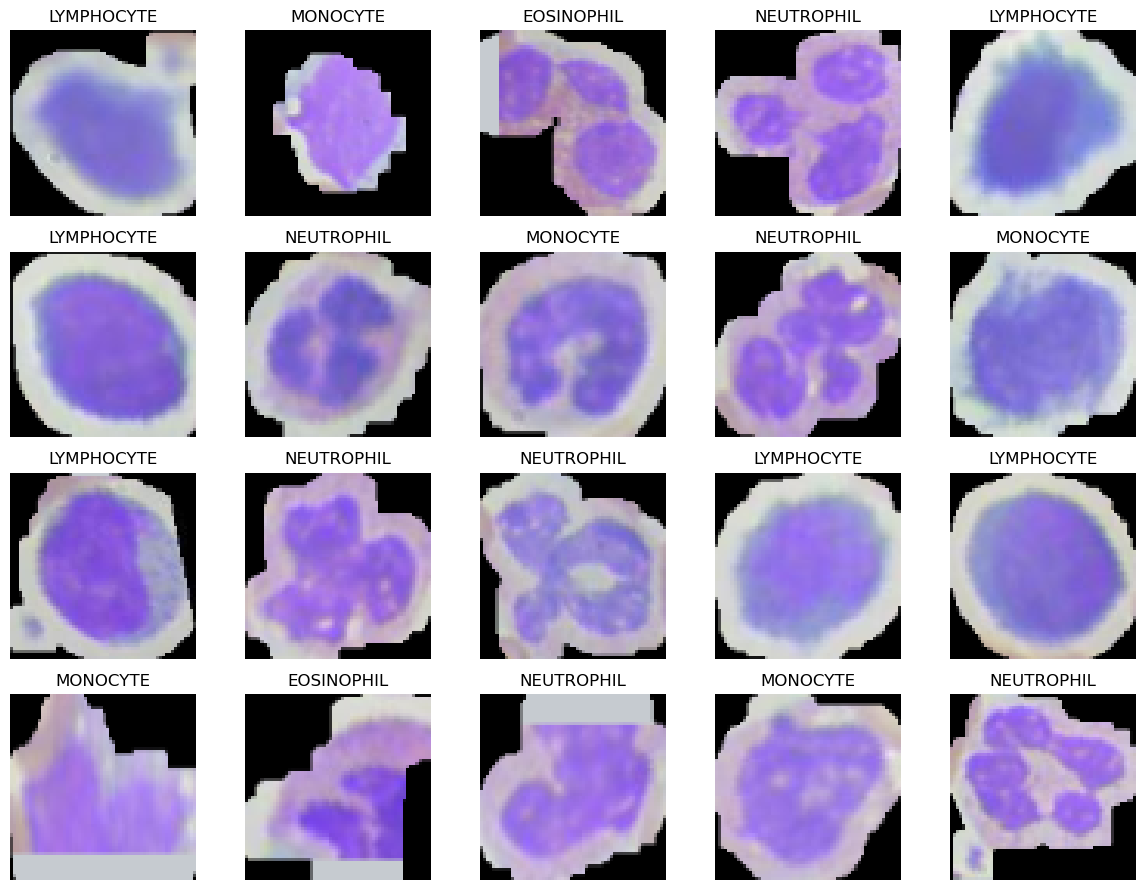

In [16]:
sample = random.sample(range(len(images)), 20)

plt.figure(figsize=(12, 9))
for i in range(len(sample)):
    plt.subplot(4, 5, i+1)
    plt.axis('off')
    plt.imshow(images[sample[i]])
    plt.title(label_code(labels[sample[i]]))
plt.tight_layout()
plt.show()

Split the set into training, test and validation sets

In [7]:
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.2)
test_images, val_images, test_labels, val_labels = train_test_split(test_images, test_labels, test_size=0.5)

## Simple CNN

In [18]:
BATCH_SIZE = 32
LEARNING_RATE = 0.001
EPOCHS = 30

Building a model

In [19]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=IMAGE_SHAPE),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(4, activation='softmax')
])

Model architecture

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 58, 58, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 29, 29, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 29, 29, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 27, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 13, 13, 128)      0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 13, 13, 128)       0

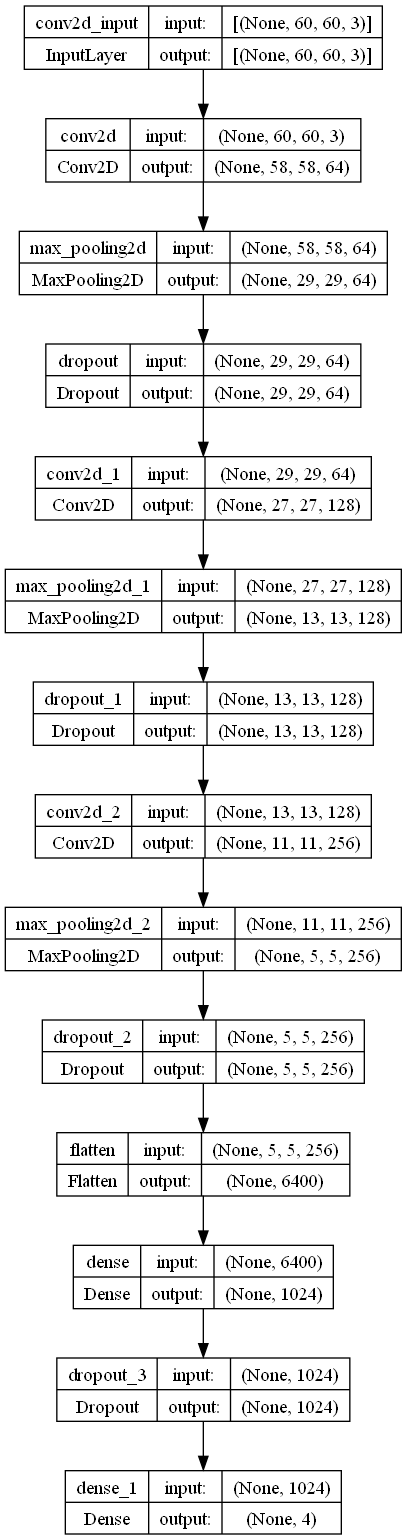

In [21]:
tf.keras.utils.plot_model(model, show_shapes=True, expand_nested=True)

Model compilation

In [22]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics = ['accuracy']
)

Model training

In [23]:
history = model.fit(
    x=train_images,
    y=train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(val_images, val_labels)
)

Epoch 1/30
304/304 [==============================] - 13s 38ms/step - loss: 1.0264 - accuracy: 0.5327 - val_loss: 0.7920 - val_accuracy: 0.6510
Epoch 2/30
304/304 [==============================] - 11s 37ms/step - loss: 0.5127 - accuracy: 0.7942 - val_loss: 0.3731 - val_accuracy: 0.8691
Epoch 3/30
304/304 [==============================] - 11s 37ms/step - loss: 0.3340 - accuracy: 0.8659 - val_loss: 0.3107 - val_accuracy: 0.8658
Epoch 4/30
304/304 [==============================] - 11s 37ms/step - loss: 0.2597 - accuracy: 0.8904 - val_loss: 0.1614 - val_accuracy: 0.9374
Epoch 5/30
304/304 [==============================] - 11s 37ms/step - loss: 0.2052 - accuracy: 0.9201 - val_loss: 0.1558 - val_accuracy: 0.9407
Epoch 6/30
304/304 [==============================] - 11s 37ms/step - loss: 0.1615 - accuracy: 0.9355 - val_loss: 0.1633 - val_accuracy: 0.9358
Epoch 7/30
304/304 [==============================] - 11s 37ms/step - loss: 0.1291 - accuracy: 0.9504 - val_loss: 0.1335 - val_accuracy:

Learning curves

In [24]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

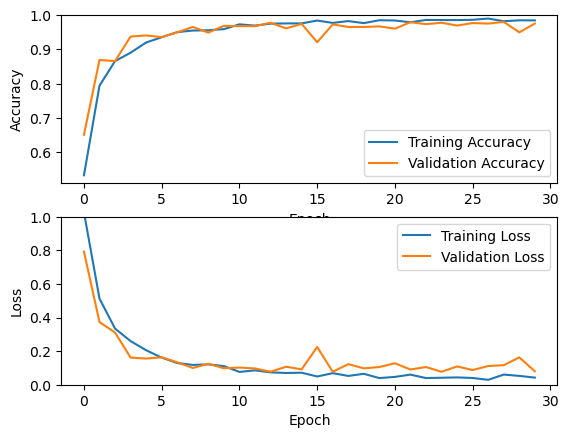

In [25]:
plt.subplot(2, 1, 1)
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.ylim([min(plt.ylim()), 1])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.show()

## Evaluation and prediction

Model predictions on test set images

In [26]:
y_true = test_labels
predictions = model.predict(test_images)
y_pred = np.argmax(predictions, axis=1)

cm = confusion_matrix(y_true, y_pred)

38/38 [==============================] - 1s 17ms/step


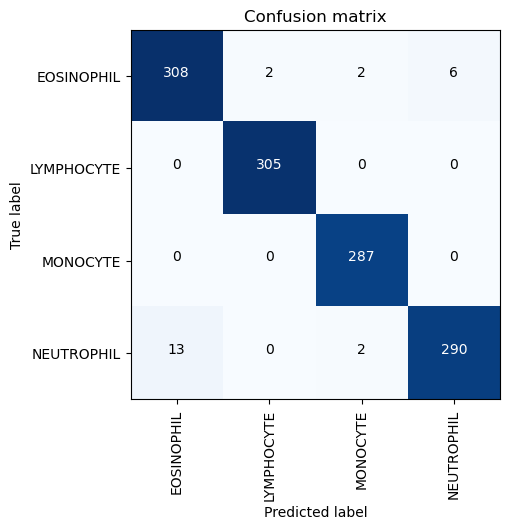

In [27]:
plt.imshow(cm, cmap=plt.cm.Blues)

plt.title('Confusion matrix')

plt.xlabel('Predicted label')
plt.ylabel('True label')

tick_marks = np.arange(len(CLASS_NAMES))
plt.xticks(tick_marks, CLASS_NAMES, rotation=90)
plt.yticks(tick_marks, CLASS_NAMES)

thresh = cm.max() / 2.0
for (i, j), n in np.ndenumerate(cm):
    plt.text(j, i, n, horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')

plt.show()

Model prediction on random images

In [35]:
images_sample = pd.DataFrame()
for class_name in CLASS_NAMES:
    df = pd.DataFrame()
    sample = random.sample(os.listdir(TEST_SIMPLE_IMAGES_PATH+class_name), 2)
    sample = [TEST_SIMPLE_IMAGES_PATH + class_name + '/' + i for i in sample]
    df['File'] = sample
    df['Class'] = class_name
    images_sample = pd.concat([images_sample, df], ignore_index=True)

In [36]:
images = []

for image_path in images_sample['File']:
    image = load_image(image_path)
    image = preprocess_image(image)
    images.append(image)

images = np.array(images)

predictions = model.predict(images)
predictions = np.argmax(predictions, axis=1)
predictions = [label_code(label) for label in predictions]

images_sample['Prediction'] = predictions

1/1 [==============================] - 0s 32ms/step


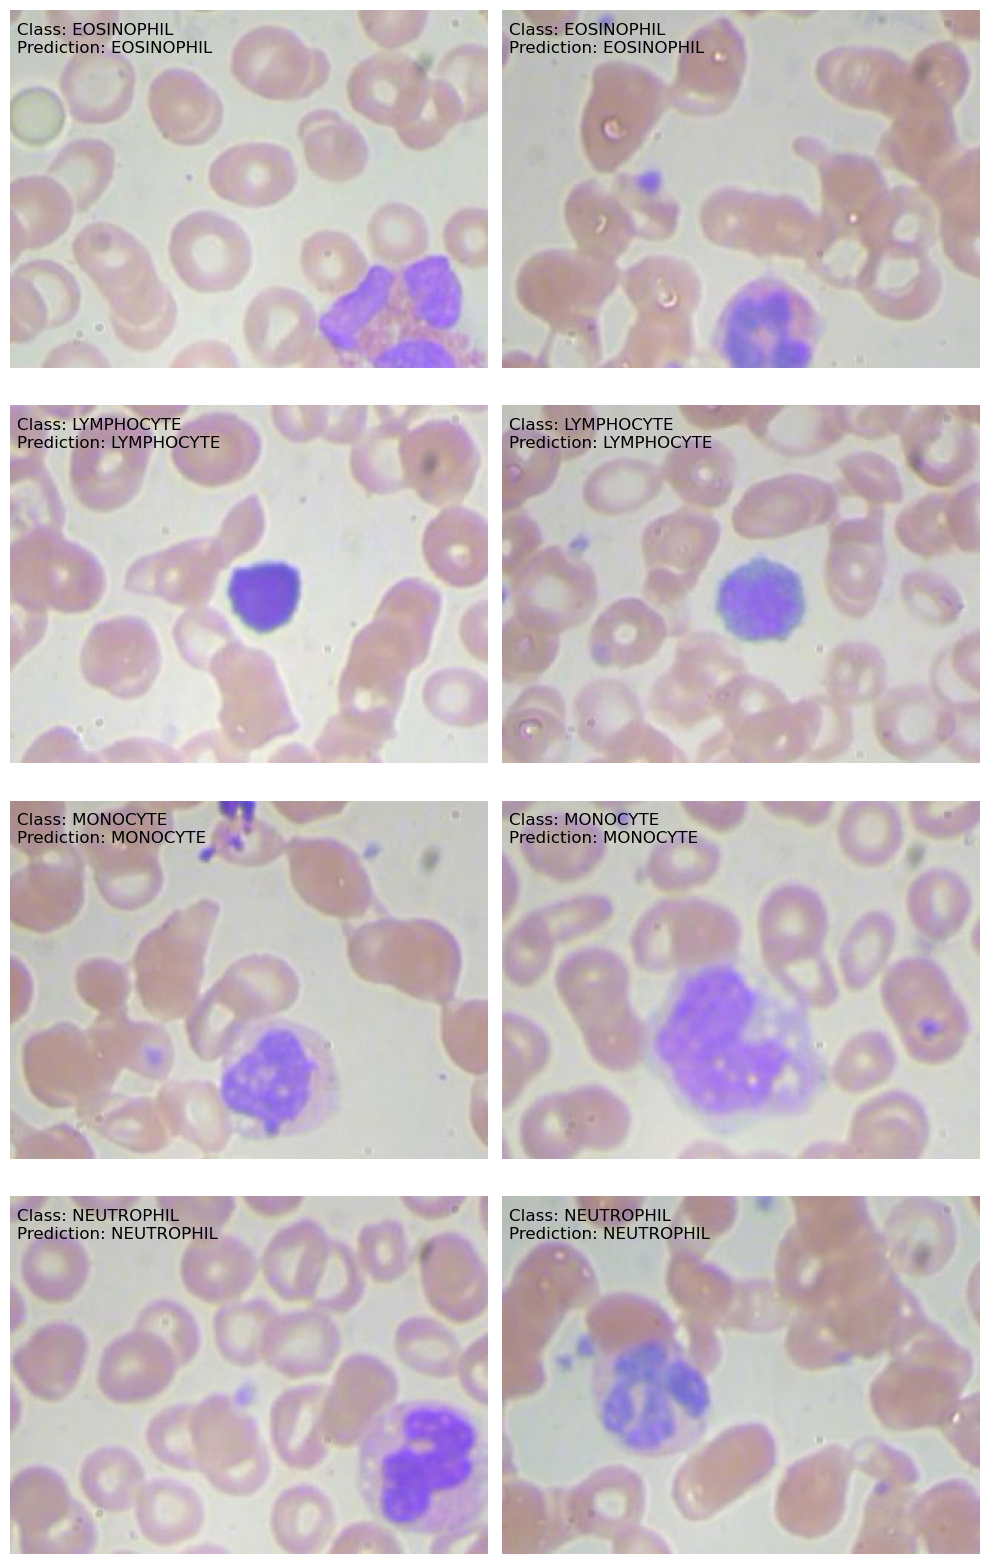

In [37]:
plt.figure(figsize=(10, 16))
for i in range(len(images_sample)):
    plt.subplot(4, 2, i+1)
    plt.axis('off')
    image = load_image(images_sample['File'][i])
    plt.imshow(image)
    plt.text(4, 16, f"Class: {images_sample['Class'][i]}", fontsize=12)
    plt.text(4, 28, f"Prediction: {images_sample['Prediction'][i]}", fontsize=12)
plt.tight_layout()
plt.show()

## DenseNet

In [8]:
BATCH_SIZE = 32
LEARNING_RATE = 0.001
INITIAL_EPOCHS = 20
FINE_TUNING_EPOCHS = 20

Building a base model from pre-trained convnets

In [9]:
base_model = tf.keras.applications.DenseNet201(
    include_top = False,
    weights = 'imagenet',
    input_tensor = None,
    input_shape = IMAGE_SHAPE,
    pooling = None
)

Base model architecture

In [10]:
base_model.summary()

Model: "densenet201"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 60, 60, 3)]  0           []                               
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 66, 66, 3)   0           ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 30, 30, 64)   9408        ['zero_padding2d[0][0]']         
                                                                                                  
 conv1/bn (BatchNormalization)  (None, 30, 30, 64)   256         ['conv1/conv[0][0]']             
                                                                                        

 conv2_block4_1_bn (BatchNormal  (None, 15, 15, 128)  512        ['conv2_block4_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block4_1_relu (Activatio  (None, 15, 15, 128)  0          ['conv2_block4_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block4_2_conv (Conv2D)   (None, 15, 15, 32)   36864       ['conv2_block4_1_relu[0][0]']    
                                                                                                  
 conv2_block4_concat (Concatena  (None, 15, 15, 192)  0          ['conv2_block3_concat[0][0]',    
 te)                                                              'conv2_block4_2_conv[0][0]']    
          

                                                                                                  
 conv3_block2_1_bn (BatchNormal  (None, 7, 7, 128)   512         ['conv3_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block2_1_relu (Activatio  (None, 7, 7, 128)   0           ['conv3_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block2_2_conv (Conv2D)   (None, 7, 7, 32)     36864       ['conv3_block2_1_relu[0][0]']    
                                                                                                  
 conv3_block2_concat (Concatena  (None, 7, 7, 192)   0           ['conv3_block1_concat[0][0]',    
 te)      

 conv3_block6_2_conv (Conv2D)   (None, 7, 7, 32)     36864       ['conv3_block6_1_relu[0][0]']    
                                                                                                  
 conv3_block6_concat (Concatena  (None, 7, 7, 320)   0           ['conv3_block5_concat[0][0]',    
 te)                                                              'conv3_block6_2_conv[0][0]']    
                                                                                                  
 conv3_block7_0_bn (BatchNormal  (None, 7, 7, 320)   1280        ['conv3_block6_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block7_0_relu (Activatio  (None, 7, 7, 320)   0           ['conv3_block7_0_bn[0][0]']      
 n)                                                                                               
          

                                                                                                  
 conv3_block11_0_relu (Activati  (None, 7, 7, 448)   0           ['conv3_block11_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv3_block11_1_conv (Conv2D)  (None, 7, 7, 128)    57344       ['conv3_block11_0_relu[0][0]']   
                                                                                                  
 conv3_block11_1_bn (BatchNorma  (None, 7, 7, 128)   512         ['conv3_block11_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv3_block11_1_relu (Activati  (None, 7, 7, 128)   0           ['conv3_block11_1_bn[0][0]']     
 on)      

 ization)                                                                                         
                                                                                                  
 conv4_block3_0_relu (Activatio  (None, 3, 3, 320)   0           ['conv4_block3_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block3_1_conv (Conv2D)   (None, 3, 3, 128)    40960       ['conv4_block3_0_relu[0][0]']    
                                                                                                  
 conv4_block3_1_bn (BatchNormal  (None, 3, 3, 128)   512         ['conv4_block3_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_blo

 conv4_block7_1_bn (BatchNormal  (None, 3, 3, 128)   512         ['conv4_block7_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block7_1_relu (Activatio  (None, 3, 3, 128)   0           ['conv4_block7_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block7_2_conv (Conv2D)   (None, 3, 3, 32)     36864       ['conv4_block7_1_relu[0][0]']    
                                                                                                  
 conv4_block7_concat (Concatena  (None, 3, 3, 480)   0           ['conv4_block6_concat[0][0]',    
 te)                                                              'conv4_block7_2_conv[0][0]']    
          

                                                                                                  
 conv4_block11_concat (Concaten  (None, 3, 3, 608)   0           ['conv4_block10_concat[0][0]',   
 ate)                                                             'conv4_block11_2_conv[0][0]']   
                                                                                                  
 conv4_block12_0_bn (BatchNorma  (None, 3, 3, 608)   2432        ['conv4_block11_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block12_0_relu (Activati  (None, 3, 3, 608)   0           ['conv4_block12_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_blo

 conv4_block16_0_relu (Activati  (None, 3, 3, 736)   0           ['conv4_block16_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block16_1_conv (Conv2D)  (None, 3, 3, 128)    94208       ['conv4_block16_0_relu[0][0]']   
                                                                                                  
 conv4_block16_1_bn (BatchNorma  (None, 3, 3, 128)   512         ['conv4_block16_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block16_1_relu (Activati  (None, 3, 3, 128)   0           ['conv4_block16_1_bn[0][0]']     
 on)                                                                                              
          

                                                                                                  
 conv4_block20_1_relu (Activati  (None, 3, 3, 128)   0           ['conv4_block20_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block20_2_conv (Conv2D)  (None, 3, 3, 32)     36864       ['conv4_block20_1_relu[0][0]']   
                                                                                                  
 conv4_block20_concat (Concaten  (None, 3, 3, 896)   0           ['conv4_block19_concat[0][0]',   
 ate)                                                             'conv4_block20_2_conv[0][0]']   
                                                                                                  
 conv4_block21_0_bn (BatchNorma  (None, 3, 3, 896)   3584        ['conv4_block20_concat[0][0]']   
 lization)

 ate)                                                             'conv4_block24_2_conv[0][0]']   
                                                                                                  
 conv4_block25_0_bn (BatchNorma  (None, 3, 3, 1024)  4096        ['conv4_block24_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block25_0_relu (Activati  (None, 3, 3, 1024)  0           ['conv4_block25_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block25_1_conv (Conv2D)  (None, 3, 3, 128)    131072      ['conv4_block25_0_relu[0][0]']   
                                                                                                  
 conv4_blo

                                                                                                  
 conv4_block29_1_conv (Conv2D)  (None, 3, 3, 128)    147456      ['conv4_block29_0_relu[0][0]']   
                                                                                                  
 conv4_block29_1_bn (BatchNorma  (None, 3, 3, 128)   512         ['conv4_block29_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block29_1_relu (Activati  (None, 3, 3, 128)   0           ['conv4_block29_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block29_2_conv (Conv2D)  (None, 3, 3, 32)     36864       ['conv4_block29_1_relu[0][0]']   
          

 on)                                                                                              
                                                                                                  
 conv4_block33_2_conv (Conv2D)  (None, 3, 3, 32)     36864       ['conv4_block33_1_relu[0][0]']   
                                                                                                  
 conv4_block33_concat (Concaten  (None, 3, 3, 1312)  0           ['conv4_block32_concat[0][0]',   
 ate)                                                             'conv4_block33_2_conv[0][0]']   
                                                                                                  
 conv4_block34_0_bn (BatchNorma  (None, 3, 3, 1312)  5248        ['conv4_block33_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_blo

 conv4_block38_0_bn (BatchNorma  (None, 3, 3, 1440)  5760        ['conv4_block37_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block38_0_relu (Activati  (None, 3, 3, 1440)  0           ['conv4_block38_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block38_1_conv (Conv2D)  (None, 3, 3, 128)    184320      ['conv4_block38_0_relu[0][0]']   
                                                                                                  
 conv4_block38_1_bn (BatchNorma  (None, 3, 3, 128)   512         ['conv4_block38_1_conv[0][0]']   
 lization)                                                                                        
          

                                                                                                  
 conv4_block42_1_bn (BatchNorma  (None, 3, 3, 128)   512         ['conv4_block42_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block42_1_relu (Activati  (None, 3, 3, 128)   0           ['conv4_block42_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block42_2_conv (Conv2D)  (None, 3, 3, 32)     36864       ['conv4_block42_1_relu[0][0]']   
                                                                                                  
 conv4_block42_concat (Concaten  (None, 3, 3, 1600)  0           ['conv4_block41_concat[0][0]',   
 ate)     

 conv4_block46_2_conv (Conv2D)  (None, 3, 3, 32)     36864       ['conv4_block46_1_relu[0][0]']   
                                                                                                  
 conv4_block46_concat (Concaten  (None, 3, 3, 1728)  0           ['conv4_block45_concat[0][0]',   
 ate)                                                             'conv4_block46_2_conv[0][0]']   
                                                                                                  
 conv4_block47_0_bn (BatchNorma  (None, 3, 3, 1728)  6912        ['conv4_block46_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block47_0_relu (Activati  (None, 3, 3, 1728)  0           ['conv4_block47_0_bn[0][0]']     
 on)                                                                                              
          

                                                                                                  
 conv5_block2_2_conv (Conv2D)   (None, 1, 1, 32)     36864       ['conv5_block2_1_relu[0][0]']    
                                                                                                  
 conv5_block2_concat (Concatena  (None, 1, 1, 960)   0           ['conv5_block1_concat[0][0]',    
 te)                                                              'conv5_block2_2_conv[0][0]']    
                                                                                                  
 conv5_block3_0_bn (BatchNormal  (None, 1, 1, 960)   3840        ['conv5_block2_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block3_0_relu (Activatio  (None, 1, 1, 960)   0           ['conv5_block3_0_bn[0][0]']      
 n)       

 ization)                                                                                         
                                                                                                  
 conv5_block7_0_relu (Activatio  (None, 1, 1, 1088)  0           ['conv5_block7_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block7_1_conv (Conv2D)   (None, 1, 1, 128)    139264      ['conv5_block7_0_relu[0][0]']    
                                                                                                  
 conv5_block7_1_bn (BatchNormal  (None, 1, 1, 128)   512         ['conv5_block7_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_blo

 conv5_block11_1_bn (BatchNorma  (None, 1, 1, 128)   512         ['conv5_block11_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block11_1_relu (Activati  (None, 1, 1, 128)   0           ['conv5_block11_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block11_2_conv (Conv2D)  (None, 1, 1, 32)     36864       ['conv5_block11_1_relu[0][0]']   
                                                                                                  
 conv5_block11_concat (Concaten  (None, 1, 1, 1248)  0           ['conv5_block10_concat[0][0]',   
 ate)                                                             'conv5_block11_2_conv[0][0]']   
          

                                                                                                  
 conv5_block15_concat (Concaten  (None, 1, 1, 1376)  0           ['conv5_block14_concat[0][0]',   
 ate)                                                             'conv5_block15_2_conv[0][0]']   
                                                                                                  
 conv5_block16_0_bn (BatchNorma  (None, 1, 1, 1376)  5504        ['conv5_block15_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block16_0_relu (Activati  (None, 1, 1, 1376)  0           ['conv5_block16_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_blo

 conv5_block20_0_relu (Activati  (None, 1, 1, 1504)  0           ['conv5_block20_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block20_1_conv (Conv2D)  (None, 1, 1, 128)    192512      ['conv5_block20_0_relu[0][0]']   
                                                                                                  
 conv5_block20_1_bn (BatchNorma  (None, 1, 1, 128)   512         ['conv5_block20_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block20_1_relu (Activati  (None, 1, 1, 128)   0           ['conv5_block20_1_bn[0][0]']     
 on)                                                                                              
          

                                                                                                  
 conv5_block24_1_relu (Activati  (None, 1, 1, 128)   0           ['conv5_block24_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block24_2_conv (Conv2D)  (None, 1, 1, 32)     36864       ['conv5_block24_1_relu[0][0]']   
                                                                                                  
 conv5_block24_concat (Concaten  (None, 1, 1, 1664)  0           ['conv5_block23_concat[0][0]',   
 ate)                                                             'conv5_block24_2_conv[0][0]']   
                                                                                                  
 conv5_block25_0_bn (BatchNorma  (None, 1, 1, 1664)  6656        ['conv5_block24_concat[0][0]']   
 lization)

 ate)                                                             'conv5_block28_2_conv[0][0]']   
                                                                                                  
 conv5_block29_0_bn (BatchNorma  (None, 1, 1, 1792)  7168        ['conv5_block28_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block29_0_relu (Activati  (None, 1, 1, 1792)  0           ['conv5_block29_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block29_1_conv (Conv2D)  (None, 1, 1, 128)    229376      ['conv5_block29_0_relu[0][0]']   
                                                                                                  
 conv5_blo

Total params: 18,321,984
Trainable params: 18,092,928
Non-trainable params: 229,056
__________________________________________________________________________________________________


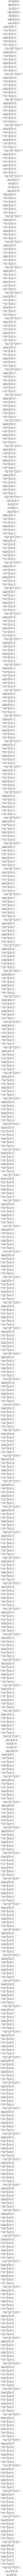

In [11]:
tf.keras.utils.plot_model(base_model, show_shapes=True, expand_nested=True)

Unfreezing convolution block 5

In [12]:
base_model.trainable = True

for layer in base_model.layers:
    if 'conv5' in layer.name:
        layer.trainable = True
    else:
        layer.trainable = False

Building a model

In [13]:
inputs = tf.keras.Input(shape=IMAGE_SHAPE)
x = base_model(inputs)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(units=256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.7)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(units=128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(units=64, activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(units=4, activation='softmax')(x)
outputs = x

model = tf.keras.Model(inputs, outputs)

Model compilation

In [14]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics = ['accuracy']
)

Model training

In [15]:
history = model.fit(
    x = train_images,
    y = train_labels,
    batch_size = BATCH_SIZE,
    epochs = INITIAL_EPOCHS,
    validation_data = (val_images, val_labels)
)

Epoch 1/20
304/304 [==============================] - 61s 129ms/step - loss: 1.1616 - accuracy: 0.5125 - val_loss: 0.6907 - val_accuracy: 0.7358
Epoch 2/20
304/304 [==============================] - 33s 109ms/step - loss: 0.7122 - accuracy: 0.7020 - val_loss: 0.4686 - val_accuracy: 0.8189
Epoch 3/20
304/304 [==============================] - 33s 109ms/step - loss: 0.5432 - accuracy: 0.7878 - val_loss: 0.3596 - val_accuracy: 0.8560
Epoch 4/20
304/304 [==============================] - 33s 109ms/step - loss: 0.4606 - accuracy: 0.8203 - val_loss: 0.3475 - val_accuracy: 0.8568
Epoch 5/20
304/304 [==============================] - 33s 109ms/step - loss: 0.3996 - accuracy: 0.8573 - val_loss: 0.3014 - val_accuracy: 0.8823
Epoch 6/20
304/304 [==============================] - 33s 109ms/step - loss: 0.3531 - accuracy: 0.8699 - val_loss: 0.3094 - val_accuracy: 0.8807
Epoch 7/20
304/304 [==============================] - 37s 122ms/step - loss: 0.3256 - accuracy: 0.8850 - val_loss: 0.2985 - val_ac

Learning curves

In [16]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

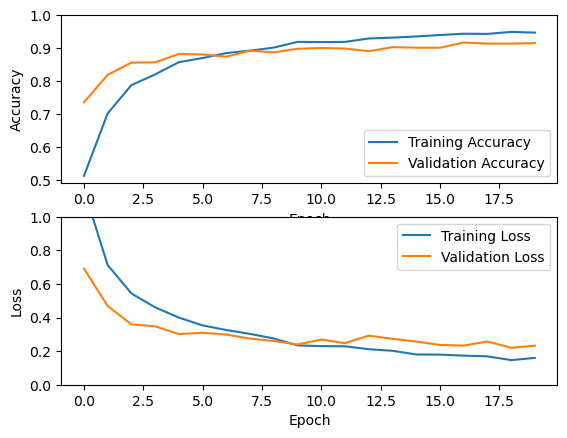

In [17]:
plt.subplot(2, 1, 1)
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.ylim([min(plt.ylim()), 1])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.show()

Unfreezing convolution block 4

In [18]:
for layer in base_model.layers:
    if 'conv4' in layer.name:
        layer.trainable = True

Model compilation

In [19]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.1*LEARNING_RATE),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics = ['accuracy']
)

Model training

In [20]:
history_fine_tuning = model.fit(
    x = train_images,
    y = train_labels,
    batch_size = BATCH_SIZE,
    epochs = INITIAL_EPOCHS + FINE_TUNING_EPOCHS,
    initial_epoch = history.epoch[-1] + 1,
    validation_data = (val_images, val_labels)
)

Epoch 21/40
304/304 [==============================] - 87s 190ms/step - loss: 0.3798 - accuracy: 0.8849 - val_loss: 0.1514 - val_accuracy: 0.9366
Epoch 22/40
304/304 [==============================] - 52s 170ms/step - loss: 0.1530 - accuracy: 0.9493 - val_loss: 0.1144 - val_accuracy: 0.9547
Epoch 23/40
304/304 [==============================] - 52s 170ms/step - loss: 0.1274 - accuracy: 0.9612 - val_loss: 0.1300 - val_accuracy: 0.9490
Epoch 24/40
304/304 [==============================] - 52s 170ms/step - loss: 0.0981 - accuracy: 0.9684 - val_loss: 0.1121 - val_accuracy: 0.9547
Epoch 25/40
304/304 [==============================] - 52s 171ms/step - loss: 0.0734 - accuracy: 0.9764 - val_loss: 0.1150 - val_accuracy: 0.9588
Epoch 26/40
304/304 [==============================] - 52s 171ms/step - loss: 0.0652 - accuracy: 0.9800 - val_loss: 0.1522 - val_accuracy: 0.9473
Epoch 27/40
304/304 [==============================] - 53s 172ms/step - loss: 0.0746 - accuracy: 0.9794 - val_loss: 0.2798 -

Learning curves

In [21]:
accuracy += history_fine_tuning.history['accuracy']
val_accuracy += history_fine_tuning.history['val_accuracy']

loss += history_fine_tuning.history['loss']
val_loss += history_fine_tuning.history['val_loss']

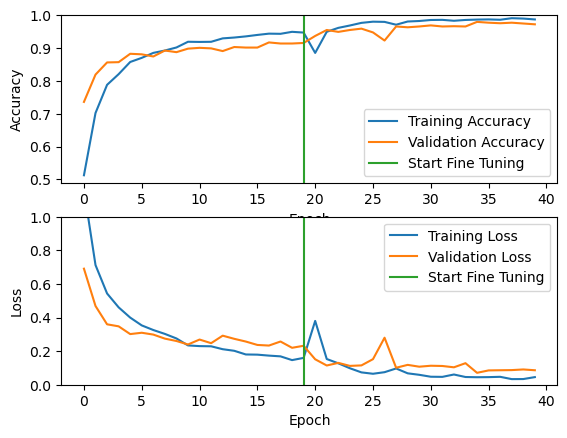

In [22]:
plt.subplot(2, 1, 1)
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.ylim([min(plt.ylim()), 1])
plt.plot([INITIAL_EPOCHS-1, INITIAL_EPOCHS-1], plt.ylim(), label='Start Fine Tuning')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1])
plt.plot([INITIAL_EPOCHS-1, INITIAL_EPOCHS-1], plt.ylim(), label='Start Fine Tuning')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.show()

## Evaluation and prediction

Model predictions on test set images

In [23]:
y_true = test_labels
predictions = model.predict(test_images)
y_pred = np.argmax(predictions, axis=1)

cm = confusion_matrix(y_true, y_pred)

38/38 [==============================] - 8s 58ms/step


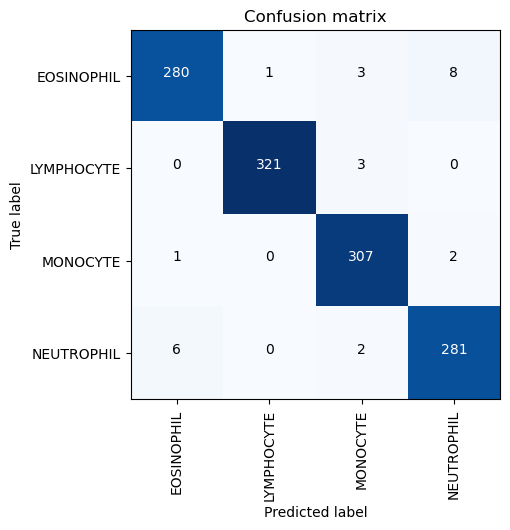

In [24]:
plt.imshow(cm, cmap=plt.cm.Blues)

plt.title('Confusion matrix')

plt.xlabel('Predicted label')
plt.ylabel('True label')

tick_marks = np.arange(len(CLASS_NAMES))
plt.xticks(tick_marks, CLASS_NAMES, rotation=90)
plt.yticks(tick_marks, CLASS_NAMES)

thresh = cm.max() / 2.0
for (i, j), n in np.ndenumerate(cm):
    plt.text(j, i, n, horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')

plt.show()

Model prediction on random images

In [27]:
images_sample = pd.DataFrame()
for class_name in CLASS_NAMES:
    df = pd.DataFrame()
    sample = random.sample(os.listdir(TEST_SIMPLE_IMAGES_PATH+class_name), 2)
    sample = [TEST_SIMPLE_IMAGES_PATH + class_name + '/' + i for i in sample]
    df['File'] = sample
    df['Class'] = class_name
    images_sample = pd.concat([images_sample, df], ignore_index=True)

In [28]:
images = []

for image_path in images_sample['File']:
    image = load_image(image_path)
    image = preprocess_image(image)
    images.append(image)

images = np.array(images)

predictions = model.predict(images)
predictions = np.argmax(predictions, axis=1)
predictions = [label_code(label) for label in predictions]

images_sample['Prediction'] = predictions

1/1 [==============================] - 0s 225ms/step


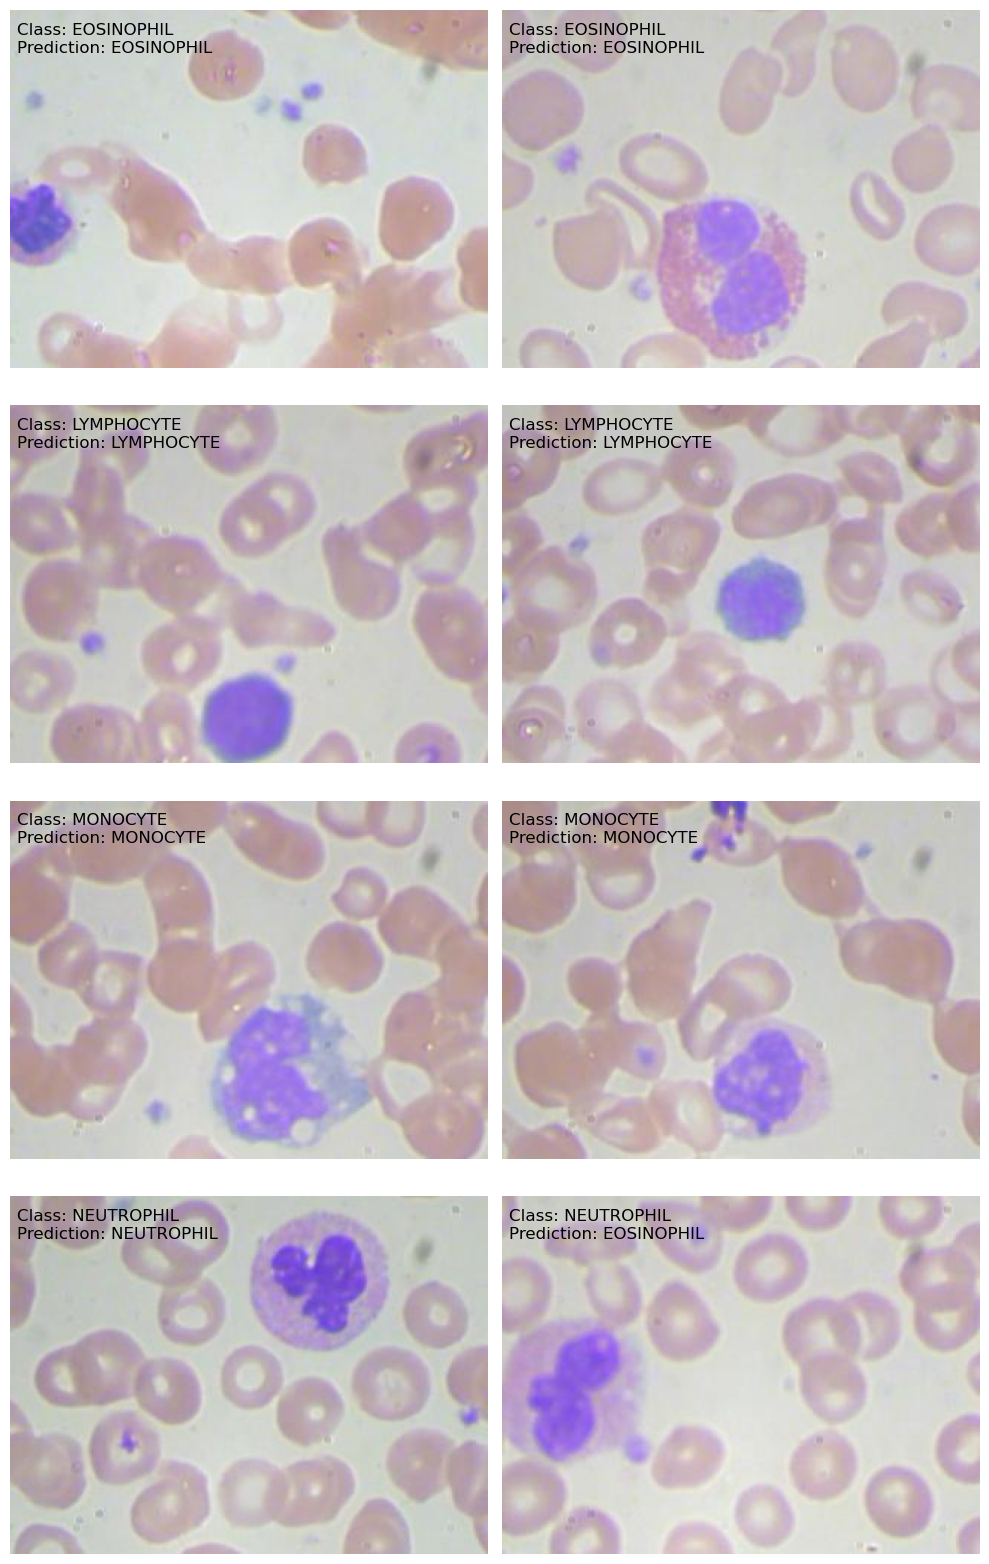

In [29]:
plt.figure(figsize=(10, 16))
for i in range(len(images_sample)):
    plt.subplot(4, 2, i+1)
    plt.axis('off')
    image = load_image(images_sample['File'][i])
    plt.imshow(image)
    plt.text(4, 16, f"Class: {images_sample['Class'][i]}", fontsize=12)
    plt.text(4, 28, f"Prediction: {images_sample['Prediction'][i]}", fontsize=12)
plt.tight_layout()
plt.show()